In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf
import arviz as az
import matplotlib.pyplot as plt

2023-01-10 11:14:58.515467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 11:14:58.684600: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import meq

In [4]:
def single_prev(params, eir):
    p = meq.default_parameters()
    (
        p.kb,
        p.ub,
        p.b0,
        p.IB0
    ) = params
    p.EIR = eir
    solution = meq.solve(p)
    prop = np.array(solution.prop)
    return np.array(solution.pos_M)[3:10].sum() / np.array(solution.prop)[3:10].sum()

In [5]:
kb = np.random.gamma(4., 1.)
ub = np.random.lognormal(1., 1.)
b0 = np.random.beta(7., 1.)
#b1 = np.random.beta(1., 10.) # This is breaking!
IB0 = np.random.gamma(40., 1.)

In [6]:
kb, ub, b0, IB0

(3.8941324531515855, 4.353225026984918, 0.9926205260860631, 41.472669936134714)

In [7]:
population = 100_000
EIR = 21.

In [8]:
observations = single_prev([kb, ub, b0, IB0], EIR) * population

In [ ]:
model = load_model('./models/eq/')

In [ ]:
default_params = pd.read_csv('default_params.csv')
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))

In [ ]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(population)

@tf.function
def model_prev(kb, ub, b0, IB0, eir):
    param_shape = kb.shape
    X_ = tf.stack([
        tf.fill(param_shape, eir),
        tf.fill(param_shape, default_dict['eta']), # default age
        tf.fill(param_shape, default_dict['Q0']),
        tf.fill(param_shape, default_dict['s2']),
        tf.fill(param_shape, default_dict['rU']),
        tf.fill(param_shape, default_dict['cD']),
        tf.fill(param_shape, default_dict['g_inf']),
        tf.fill(param_shape, default_dict['cU']),
        kb,
        ub,
        tf.fill(param_shape, default_dict['uc']),
        tf.fill(param_shape, default_dict['ud']),
        tf.fill(param_shape, default_dict['kc']),
        b0,
        tf.fill(param_shape, default_dict['b1']),
        IB0,
        tf.fill(param_shape, default_dict['IC0']),
        tf.fill(param_shape, default_dict['tau']),
        tf.fill(param_shape, default_dict['phi0']),
        tf.fill(param_shape, default_dict['phi1']),
        tf.fill(param_shape, default_dict['mu']),
        tf.fill(param_shape, default_dict['f']),
        tf.fill(param_shape, default_dict['fd0']),
        tf.fill(param_shape, default_dict['ad0']),
        tf.fill(param_shape, default_dict['gd'])
    ], axis=len(param_shape))
    if len(X_.shape) == 1:
        X_ = tf.expand_dims(X_, axis=0)
    return model(clipper(X_))[:,0]

@tf.function
def prob_prev(kb, ub, b0, IB0, eir):
    prev_pred = model_prev(kb, ub, b0, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=population, probs=prev_pred, validate_args=True),
        reinterpreted_batch_ndims=1
    )

In [9]:
def model_prev(kb, ub, b0, IB0, eir):
    if len(kb.shape) == 0:
        return []
    return np.array([single_prev([kb[i], ub[i], b0[i], IB0[i]], eir) for i in range(kb.shape[0])], dtype=np.float32)

def prob_prev(kb, ub, b0, IB0, eir):
    prev_pred = model_prev(kb, ub, b0, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=population, probs=prev_pred, validate_args=True),
        reinterpreted_batch_ndims=1
    )

In [10]:
prob_prev(tf.constant([kb]), tf.constant([ub]), tf.constant([b0]), tf.constant([IB0]), tf.constant(EIR))#.sample(100)#.log_prob(observations)

2023-01-10 11:15:15.812980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 11:15:16.743205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 719 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2023-01-10 11:15:16.745036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37815 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


<tfp.distributions.Independent 'IndependentBinomial' batch_shape=[] event_shape=[1] dtype=float32>

In [11]:
model_prev(tf.constant([kb]), tf.constant([ub]), tf.constant([b0]), tf.constant([IB0]), tf.constant(EIR))

array([0.65663165], dtype=float32)

In [12]:
from collections import OrderedDict

joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Uniform(0., 100., validate_args=True), #kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.Uniform(0., 100., validate_args=True), #ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Uniform(0., 1., validate_args=True), #b0 = tfd.Beta(7., 1., validate_args=True),
        #b1_reduction = tfd.Beta(7., 1., validate_args=True),
        IB0 = tfd.Uniform(1., 100., validate_args=True),#IB0 = tfd.Gamma(40., 1., validate_args=True),
        prev = lambda kb, ub, b0, IB0: prob_prev(kb, ub, b0, IB0, tf.constant(EIR))
    )
)

In [13]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

(array([ 17.,  22.,  22.,  46.,  55.,  63.,  87., 152., 232., 304.]),
 array([  833.        ,  7470.70019531, 14108.40039062, 20746.09960938,
        27383.80078125, 34021.5       , 40659.19921875, 47296.8984375 ,
        53934.6015625 , 60572.30078125, 67210.        ]),
 <BarContainer object of 10 artists>)

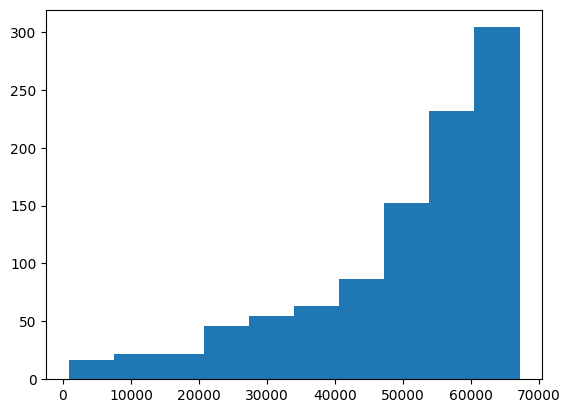

In [14]:
plt.hist(prior_predictive)

In [15]:
observations

65663.16464901234

In [16]:
num_chains = 10

observed_prev = tf.constant(np.round(observations), dtype=tf.float32)
pinned_joint_dist = joint_dist.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())
param_scales = [
    .05, # kb,
    .05, # ub,
    .01,# b0,
    .05 # IB0
]
parameter_names = pinned_joint_dist._flat_resolve_names()

In [17]:
%%time

# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 1000 #int(1e3)
num_burnin_steps = 1000 #100 #int(1e3)

initial_step_size = [
    tf.constant(1e-1, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob(*state):
    return pinned_joint_dist.unnormalized_log_prob(state)

# mcmc = tfp.mcmc.TransformedTransitionKernel(
#     tfp.mcmc.SimpleStepSizeAdaptation(
#         inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
#             target_log_prob_fn=log_prob,
#             num_leapfrog_steps=50,
#             step_size=initial_step_size
#         ),
#         num_adaptation_steps=int(num_burnin_steps * 0.8)#int(num_burnin_steps * 0.8)
#     ),
#     pinned_joint_dist.experimental_default_event_space_bijector().bijectors
# )

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=log_prob,
        new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=param_scales)
    ),
    pinned_joint_dist.experimental_default_event_space_bijector().bijectors
)

# Add a progress bar
pbar = tfp.experimental.mcmc.ProgressBarReducer(num_results + num_burnin_steps)
mcmc = tfp.experimental.mcmc.WithReductions(mcmc, pbar)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

100%|████████████████████████████████████▉| 1999/2000 [02:18<00:00, 15.04it/s]

CPU times: user 2min 30s, sys: 3.76 s, total: 2min 34s
Wall time: 2min 18s


In [18]:
acceptance.numpy().mean()

0.5087

In [19]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [20]:
posterior_predictive = tf.concat([
    list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ..., tf.newaxis]
    for chain in range(num_chains)
], 0)

100%|████████████████████████████████████▉| 1999/2000 [02:30<00:00, 15.04it/s]

In [21]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ..., tf.newaxis]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(1), "param": np.arange(len(parameter_names))},
    observed_data={"observations": observations},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [22]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "ess_bulk", "r_hat"]))

       mean  hdi_3%  hdi_97%  ess_bulk  r_hat
kb   63.416  21.056   98.558      11.0   3.54
ub   62.092   7.943   98.676      11.0   4.21
b0    0.794   0.664    0.896      12.0   2.34
IB0  63.646  25.205   99.763      11.0   3.32


In [23]:
(kb, ub, b0, IB0)

(3.8941324531515855, 4.353225026984918, 0.9926205260860631, 41.472669936134714)

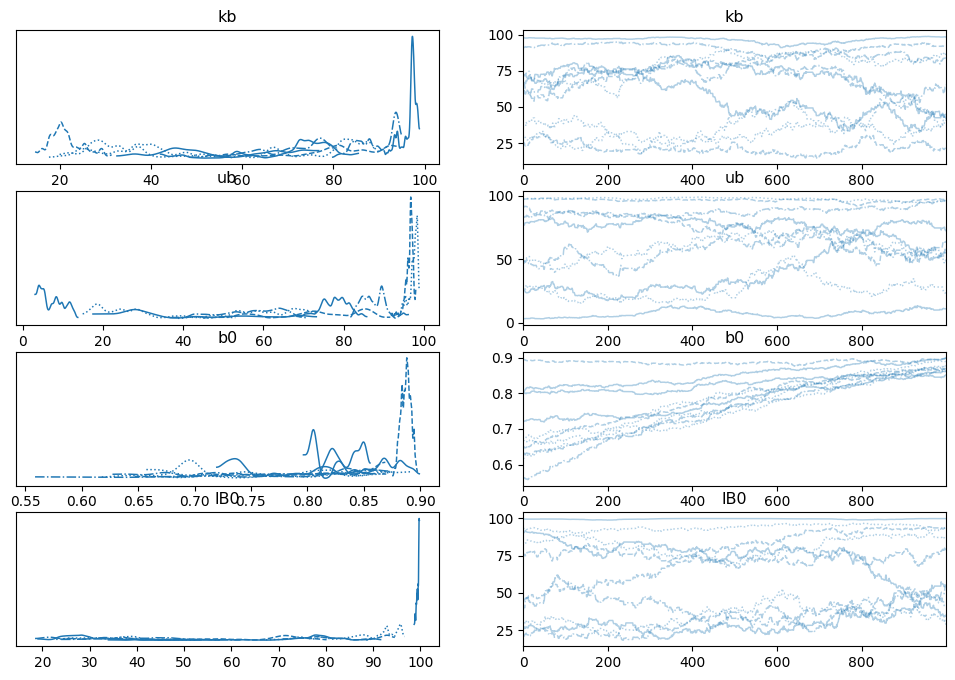

In [24]:
axs = az.plot_trace(trace, var_names=['kb', 'ub', 'b0', 'IB0'])

In [ ]:
axs = az.plot_dist_comparison(trace)

In [ ]:
plt.hist(tfd.LogNormal(0., 1.).sample(1000))

In [ ]:
plt.plot(samples[0][:,3])

In [ ]:
samples